<a href="https://www.kaggle.com/code/mbhosseini70/urban-sound-classification?scriptVersionId=160453724" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="padding:10px;background-color:#0077b6;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Urban Sound Classification using Deep Learning and Transfer Learning</p>


## Table of Contents
<p style="margin:20px;font-size:120%">
1. <a href="#introduction">Introduction</a><br>
2. <a href="#imports">Setting Up the Environment and Data Loading</a><br>
3. <a href="#FE_V">Feature Extraction and Visualization</a><br>
4. <a href="#data-preprocessing">Preprocessing for Deep Learning</a><br>
5. <a href="#MP_TL">Model Preparation using Transfer Learning</a><br>
6. <a href="#MT_E_V">Model Training, Evaluation and Visualization</a><br>
</p>



## <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="introduction" style="color:white;text-decoration:none">1. Introduction</a></p>
<p style="margin:20px;font-size:120%;text-align:justify">The goal of this project is to classify urban sounds into various categories using a combination of deep learning and transfer learning techniques. The approach involves processing audio data into Mel spectrograms and employing a Convolutional Neural Network (CNN) model, specifically leveraging the power of transfer learning with the InceptionV3 pre-trained model.</p>

## <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="imports" style="color:white;text-decoration:none">2. Installing and Importing Necessary Libraries and Reading Dataset</a></p>
<p style="margin:20px;font-size:120%;text-align:justify">
    In this part, we will import the required libraries and also read the dataset. 
    <span style="font-weight:bold; color:#FF0000;">An important point here is the installation of 'resampy'.</span> 
    This library is used in the 'features_extract' method to create a Melspectrogram from an audio file. 
    'Resampy' is a Python library that provides efficient resampling of audio signals, utilizing various filters and methods to achieve high-quality audio processing. 
    Its key features include high-quality resampling algorithms and an easy-to-use interface, making it a popular choice for audio signal processing tasks. 
    <span style="font-weight:bold; color:#FF0000;">After installing this library with pip, you need to restart the session to continue running the code; otherwise, you will face an error.</span>
</p>




In [ ]:
pip install resampy

In [3]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline
import seaborn as sns

# Specific Libraries
import os
import librosa
import librosa.display
import IPython.display as ipd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm, trange
from tqdm.auto import tqdm


from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
df = pd.read_csv("../input/urbansound8k/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="FE_V" style="color:white;text-decoration:none">3. Feature Extraction and Visualization</a></p>
<p style="margin:20px;font-size:120%;text-align:justify">In this section, I focus on generating Mel spectrograms from audio files using the librosa library.  A Mel spectrogram is a visual representation of the spectrum of frequencies in a sound signal as they vary with time. It differs from a standard spectrogram by scaling the frequency axis to match more closely with human auditory perception. Mel spectrograms are widely used in audio processing as they represent sound in a way that is more meaningful for analysis and classification tasks.<br><br>
    <span style="font-weight:bold; ">For this project, the script has been configured to process only the first 4000 audio files from the dataset. This restriction has been implemented due to limitations in available computational memory and processing power. In the pursuit of enhancing our project, I am open to suggestions. If you have any insights or strategies that could help overcome this challenge, your input would be highly valued and appreciated.</span><br><br>
In the final step of this section, I will present a sample output as an image. 
</p>



In [5]:
def features_extract(file):
    # Load the file
    sample, sample_rate = librosa.load(file, res_type='kaiser_fast')
    # Generate a Melspectrogram
    spectrogram = librosa.feature.melspectrogram(y = sample, sr = sample_rate)
    spectrogram_db_mel = librosa.amplitude_to_db(spectrogram ,ref= np.max)

    return spectrogram_db_mel

# Initialize an empty list to store extracted features and class labels
extracted_features = []

# Define the path 
path = '../input/urbansound8k/'

# Initialize a counter for the samples
sample_count = 0

for _, row in tqdm(df.iterrows()):
    if sample_count < 4000:
        # Construct the full file path
        file_name = os.path.join(os.path.abspath(path), 'fold' + str(row["fold"]), str(row['slice_file_name']))
        
        # Extract class labels
        class_label = row['class']
        
        # Extract features using the function
        features = features_extract(file_name)
        
        # Append the features and class label to the list
        extracted_features.append([features, class_label])

        # Increment the sample counter
        sample_count += 1
    else:
        break

# Convert the list to a DataFrame
extracted_df = pd.DataFrame(extracted_features, columns=['spectrogram', 'class'])

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


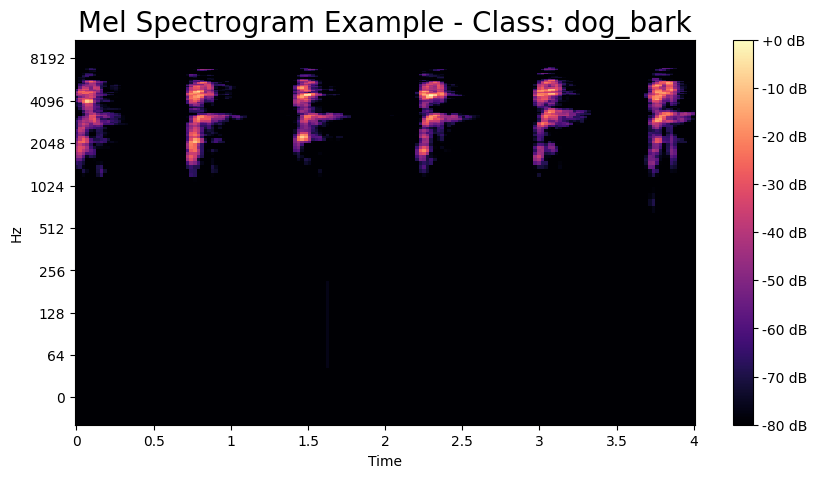

In [6]:
# Select the first sample from the extracted features
first_sample_spectrogram, first_sample_class = extracted_features[20]

# Display the spectrogram using matplotlib
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(first_sample_spectrogram, x_axis='time', y_axis='log', ax=ax)

# Set the title to include the class label
ax.set_title(f'Mel Spectrogram Example - Class: {first_sample_class}', fontsize=20)

# Optionally, you can add a colorbar to the plot to represent the amplitude
fig.colorbar(img, ax=ax, format='%+2.0f dB')

plt.show()


## <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="data-preprocessing" style="color:white;text-decoration:none">4. Preprocessing for Deep Learning</a></p>
<p style="margin:20px;font-size:140%;text-align:justify">
    In this section, I will undertake the following five essential steps in data preprocessing tailored for deep learning applications:
    <ol>
        <li><strong>Resize the Spectrograms:</strong> Adjust the size of the spectrograms to 299x299 pixels to meet the input requirements of the InceptionV3 model.</li>
        <li><strong>Channel Modification:</strong> Convert the data to have three channels by replicating the single channel. This process creates a structure akin to RGB channels, which is a standard format for image data in deep learning models.</li>
        <li><strong>Preprocess for InceptionV3:</strong> Process the spectrogram data to ensure compatibility with the InceptionV3 architecture and encode the class labels in a one-hot format for effective categorization.</li>
         <li><strong>Label Encoding:</strong> Encode the class labels in a one-hot format</li>
        <li><strong>Data Splitting:</strong> Divide the dataset into training and testing sets</li>
    </ol>
</p>

In [7]:
# Function to resize spectrograms
def resize_spectrograms(df, target_size=(299, 299)):
    resized_spectrograms = []
    for spectrogram in df['spectrogram']:
        resized = resize(spectrogram, target_size, mode='constant', anti_aliasing=True)
        resized_spectrograms.append(resized)
    return np.array(resized_spectrograms)

In [8]:
# Resize the spectrograms in the dataset
X = resize_spectrograms(extracted_df)
X = X[..., np.newaxis]  # Add channel dimension
X = np.repeat(X, 3, axis=3)  # Repeat the channel to have 3 channels

# Preprocess the input for InceptionV3
X = preprocess_input(X)



In [9]:
# Encode the class labels
label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(extracted_df['class']))


In [21]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="MP_TL" style="color:white;text-decoration:none">5. Model Preparation using Transfer Learning</a></p>
<p style="margin:20px;font-size:120%;text-align:justify">
    In this section, I will following four essential steps:
    <ol>
        <li><strong>Loading the InceptionV3 Model</strong> </li>
        <li><strong>Freezing the Layers</strong> </li>
        <li><strong>Adding Custom Layers</strong> </li>
         <li><strong>Defining and Compiling the Complete Model:</strong> </li>
    </ol>
</p>





In [26]:
# Load InceptionV3 pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(y.shape[1], activation='softmax')(x)


# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



## <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="MT_E_V" style="color:white;text-decoration:none">6. Model Training, Evaluation and Visualization</a></p>
<p style="margin:20px;font-size:120%;text-align:justify">
    In this section, I will following four essential steps:
    <ol>
        <li><strong>Loading the InceptionV3 Model</strong> </li>
        <li><strong>Freezing the Layers</strong> </li>
        <li><strong>Adding Custom Layers</strong> </li>
         <li><strong>Defining and Compiling the Complete Model:</strong> </li>
    </ol>
</p>


In [27]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

# Save the model
model.save('my_inceptionv3_model.h5')

Epoch 1/10
160/160 [==============================] - 18s 75ms/step - loss: 1.4801 - accuracy: 0.4719 - val_loss: 1.0274 - val_accuracy: 0.6328
Epoch 2/10
160/160 [==============================] - 9s 55ms/step - loss: 0.9635 - accuracy: 0.6504 - val_loss: 0.8517 - val_accuracy: 0.6781
Epoch 3/10
160/160 [==============================] - 9s 54ms/step - loss: 0.7987 - accuracy: 0.7145 - val_loss: 0.8149 - val_accuracy: 0.7344
Epoch 4/10
160/160 [==============================] - 10s 60ms/step - loss: 0.7163 - accuracy: 0.7410 - val_loss: 0.6965 - val_accuracy: 0.7609
Epoch 5/10
160/160 [==============================] - 9s 55ms/step - loss: 0.5866 - accuracy: 0.7965 - val_loss: 0.6309 - val_accuracy: 0.7953
Epoch 6/10
160/160 [==============================] - 9s 55ms/step - loss: 0.5646 - accuracy: 0.8004 - val_loss: 0.5808 - val_accuracy: 0.8000
Epoch 7/10
160/160 [==============================] - 9s 55ms/step - loss: 0.5130 - accuracy: 0.8156 - val_loss: 0.5528 - val_accuracy: 0.82

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/tmp/ipykernel_295/883113861.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


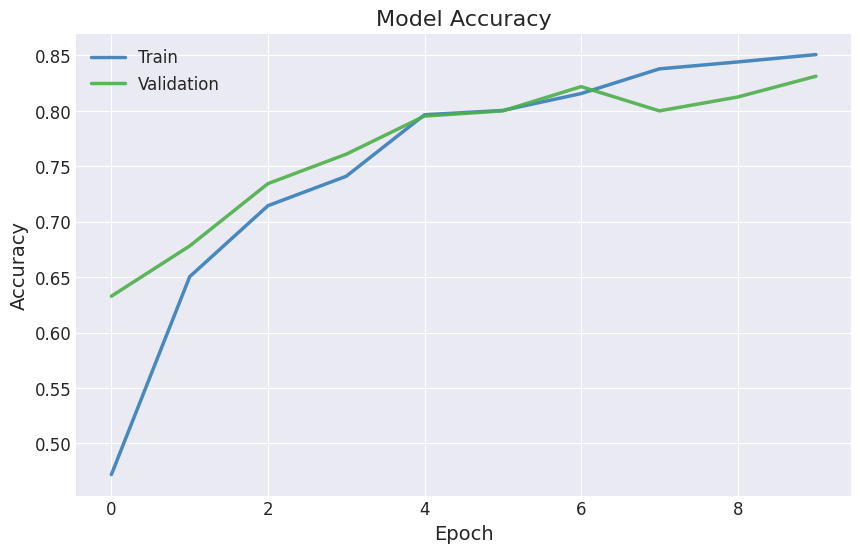

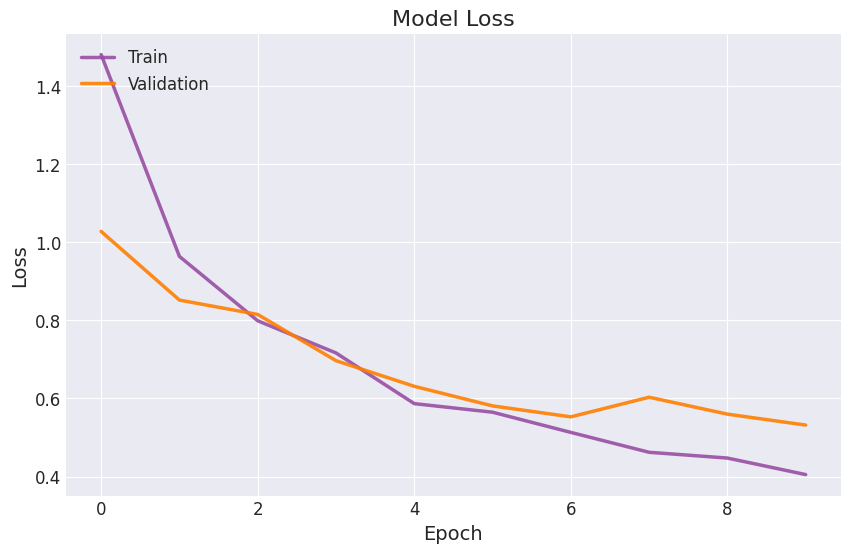

In [28]:
# Set the style of the plot
plt.style.use('seaborn-darkgrid')

# Create a color palette
palette = plt.get_cmap('Set1')

# Plot training & validation accuracy
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], marker='', color=palette(1), linewidth=2.5, alpha=0.9, label='Train')
plt.plot(history.history['val_accuracy'], marker='', color=palette(2), linewidth=2.5, alpha=0.9, label='Validation')
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

# Plot training & validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], marker='', color=palette(3), linewidth=2.5, alpha=0.9, label='Train')
plt.plot(history.history['val_loss'], marker='', color=palette(4), linewidth=2.5, alpha=0.9, label='Validation')
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [29]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

25/25 [==============================] - 4s 78ms/step - loss: 0.5398 - accuracy: 0.8250
Test accuracy: 0.824999988079071, Test loss: 0.5398480892181396
